In [1]:
from datasets import Dataset
import torch
import os
from optuna.visualization.matplotlib import plot_param_importances
import pandas as pd
import pickle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from typing import List, Dict, Any

dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
data_path = os.path.join(dir_path, "data", "wice")
save_dir = os.path.join(dir_path, "models", "setfit", "wice_classifier")

/home/venky/miniconda3/envs/grounding/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Miscellaneous helper functions

In [27]:
def binary_indices(row_data: pd.Series) -> List:
    """
    Convert list of indices to list of binary values indicating whether the corresponding
    evidence sentence supports or not.

    Args:
        row_data (Series): row of WiCE dataset to apply changes to.

    Returns:
        List: list of binary values corresponding to the list of sentences in the 'evidence' column,
        where 0's are for 'not support' sentences and 1's for 'support' sentences.
    """
    indices = sorted(
        list(
            set(
                item for sublist in row_data["supporting_sentences"] for item in sublist
            )
        )
    )
    binary_array = [int(i in indices) for i in range(len(row_data["evidence"]))]
    return binary_array


def prepare_wice_data() -> (pd.DataFrame, pd.DataFrame):
    """
    Loads WiCE train and dev data and formats the data for model training.
    Note: train and dev files from `https://github.com/ryokamoi/wice/data/entailment_retrieval/claims`

    Returns:
        (DataFrame, DataFrame): train and dev dataframes with just the evidence and supporting sentences as columns.
    """

    df_train = pd.read_json(f"{data_path}/train.jsonl", lines=True)
    df_train["label"] = df_train.apply(binary_indices, axis=1)
    df_train.drop(["supporting_sentences", "claim", "meta"], axis=1, inplace=True)

    df_dev = pd.read_json(f"{data_path}/dev.jsonl", lines=True)
    df_dev["label"] = df_dev.apply(binary_indices, axis=1)
    df_dev.drop(["supporting_sentences", "claim", "meta"], axis=1, inplace=True)

    df_train = df_train.explode(["label", "evidence"], ignore_index=True)
    df_dev = df_dev.explode(["label", "evidence"], ignore_index=True)

    return df_train, df_dev


def model_init(params: Any):
    """
    Initialises SetFit model with parameters.
    """
    params = params or {}
    max_iter = params.get("max_iter", 150)
    solver = params.get("solver", "saga")
    fithead = params.get("use_differentiable_head", True)
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }

    # Load SetFit Model.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    checkpoint = "sentence-transformers/paraphrase-mpnet-base-v2"
    return SetFitModel.from_pretrained(checkpoint, **params).to(device=device)

def hp_space(trial: Any):
    """
    Hyperparameter space
    """
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 5),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16]),
        "num_iterations": trial.suggest_categorical("num_iterations", [5, 10, 20]),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"]),
    }

def compute_metrics(labels: List, preds: List) -> Dict:
    """
    Calculates metrics during training and/or evaluation

    Args:
        labels (List): List of true labels.
        preds (List): List of predicted labels.

    Returns:
        Dict: various metric values
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def my_objective(metrics: Any) -> Any:
    """
    Objective metric to optimize for

    Args:
        metrics: metric(s) from which to optimize for
    
    Returns:
        Any: a single metric
    """
    return metrics['f1']

def save_run(run: Any) -> None:
    """
    Save BestRun object containing model parameters after hyperparameter tuning as pickle.

    Args:
        run (Any): setfit BestRun object to store
    """
    with open(f"{save_dir}/best_run.pkl", "wb") as file:
        pickle.dump(run, file)

def load_run(file_location=None) -> Any:
    """
    Loads BestRun object containing model parameters for instantiating a SetFitmodel.

    Args:
        file_location: string containing the file location
    
    Returns:
        Any: setfit BestRun object
    """
    file_location = f"{save_dir}/best_run.pkl" if not file_location else file_location
    with open(file_location, "rb") as file:
        return pickle.load(file)


## SetFit

### Hyperparameter tuning

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
[I 2023-11-10 17:42:06,019] A new study created in memory with name: no-name-cfd2d3da-b2bd-4299-9e62-403552839c9e
Trial: {'learning_rate': 4.098178171941656e-06, 'num_epochs': 3, 'batch_size': 4, 'num_iterations': 20, 'max_iter': 80, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 1302.96it/s]
***** Running training *****
  Num examples = 1280
  Num epochs = 3
  Total optimization steps = 960
  Total train batch size = 4
Epoch: 100%|██████████| 3/3 [01:07<00:00, 22.61s/it]
Applying column mapping to evaluation dataset
***** Running evalu

AttributeError: 'Dataset' object has no attribute 'columns'

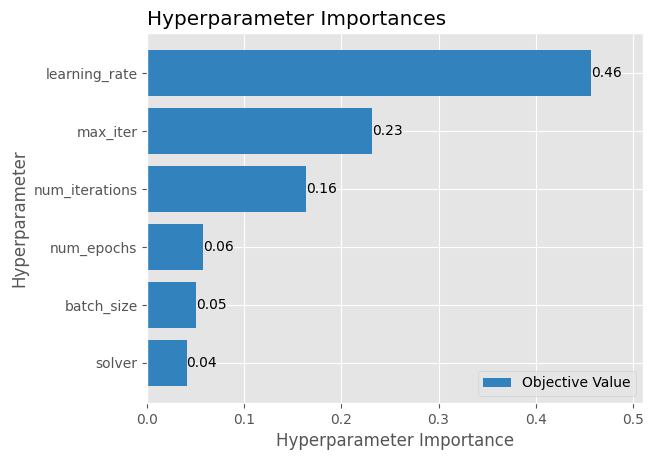

In [14]:
train_data, dev_data = prepare_wice_data()
train_dataset = Dataset.from_pandas(train_data)
train_dataset = sample_dataset(train_dataset, num_samples=16)
val_dataset = Dataset.from_pandas(dev_data)

trainer = SetFitTrainer(
    model_init=model_init,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    column_mapping={"evidence": "text", "label": "label"},
    metric=compute_metrics
)

# Perform Hyperparameter tuning
best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=100, compute_objective=my_objective)
plot_param_importances(best_run.backend)

# Store information
save_run(best_run)
temp_df = Dataset.to_pandas(train_dataset)
temp_df.to_csv(f'{save_dir}/train_small.csv', index=False)
dev_data['predictions'] = trainer.model.predict(x_test=dev_data['evidence'], as_numpy=True, show_progress_bar=True)
dev_data.to_csv(f'{save_dir}/dev_small.csv', index=False)

### Scikit-Learn classification Head

In [29]:
# Take amount of train labels corresponding to support (imbalanced compared to no support) as the total number of samples.
train_data, dev_data = prepare_wice_data()
nsamples = len(train_data[train_data['label'] == 1]) # ~4427 rows
train_dataset = Dataset.from_pandas(train_data)
train_dataset = sample_dataset(train_dataset, num_samples=nsamples)
val_dataset = Dataset.from_pandas(dev_data)

trainer = SetFitTrainer(
    model_init=model_init,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    column_mapping={"evidence": "text", "label": "label"},
    metric=compute_metrics,
)

best_run = load_run()
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)

# Train and evaluate
trainer.train() # Train only the body
with torch.no_grad():
  metrics = trainer.evaluate()
  print(metrics)

temp_df = Dataset.to_pandas(train_dataset)
temp_df.to_csv(f'{save_dir}/train_full.csv', index=False)
dev_data['predictions'] = trainer.model.predict(x_test=dev_data['evidence'], as_numpy=True, show_progress_bar=True)
dev_data.to_csv(f'{save_dir}/dev_full.csv', index=False)

trainer.model._save_pretrained(save_directory=save_dir)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]
***** Running training *****
  Num examples = 354160
  Num epochs = 3
  Total optimization steps = 265620
  Total train batch size = 4
Epoch: 100%|██████████| 3/3 [5:14:00<00:00, 6280.07s/it]  
Applying column mapping to evaluation dataset
***** Running evaluation *****
/home/venky/miniconda3/envs/grounding/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` 

{'accuracy': 0.9648441247002398, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}


Batches: 100%|██████████| 1304/1304 [00:18<00:00, 71.27it/s] 


### SetFithead classification head

In [30]:
def model_init(params):
    """
    Initialises SetFit model with parameters.
    """
    params = params or {}
    params = {
        "use_differentiable_head": True,
        "head_params": {
            "out_features": 2
        }
    }

    # Load SetFit Model.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    checkpoint = "sentence-transformers/paraphrase-mpnet-base-v2"
    return SetFitModel.from_pretrained(checkpoint, **params).to(device=device)

In [31]:
# Take amount of train labels corresponding to support (imbalanced compared to no support) as the total number of samples.
train_data, dev_data = prepare_wice_data()
nsamples = len(train_data[train_data['label'] == 1]) # ~4427 rows
train_dataset = Dataset.from_pandas(train_data)
train_dataset = sample_dataset(train_dataset, num_samples=nsamples)
val_dataset = Dataset.from_pandas(dev_data)

trainer = SetFitTrainer(
    model_init=model_init,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    column_mapping={"evidence": "text", "label": "label"},
    metric=compute_metrics,
)

best_run = load_run()
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)

# Train and evaluate
trainer.freeze() # Freeze the head
trainer.train() # Train only the body

# Unfreeze the head and unfreeze the body -> end-to-end training
trainer.unfreeze(keep_body_frozen=False)

trainer.train(
    num_epochs=25, # The number of epochs to train the head or the whole model (body and head)
    batch_size=16,
    body_learning_rate=1e-5, # The body's learning rate
    learning_rate=1e-2, # The head's learning rate
    l2_weight=0.0, # Weight decay on **both** the body and head. If `None`, will use 0.01.
)

with torch.no_grad():
  metrics = trainer.evaluate()
  print(metrics)

temp_df = Dataset.to_pandas(train_dataset)
temp_df.to_csv(f'{save_dir}_setfithead/train_full.csv', index=False)
dev_data['predictions'] = trainer.model.predict(x_test=dev_data['evidence'], as_numpy=True, show_progress_bar=True)
dev_data.to_csv(f'{save_dir}_setfithead/dev_full.csv', index=False)

trainer.model._save_pretrained(save_directory=save_dir + "_setfithead")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
***** Running training *****
  Num examples = 354160
  Num epochs = 3
  Total optimization steps = 265620
  Total train batch size = 4
Epoch: 100%|██████████| 3/3 [5:13:33<00:00, 6271.11s/it]  
Applying column mapping to training dataset
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.
Epoch: 100%|██████████| 25/25 [1:21:30<00:00, 195.62s/it]
Applying column mapping to evaluation dataset
***** Running evaluation *****
/home/venky/miniconda3/e

{'accuracy': 0.9648441247002398, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}


Batches: 100%|██████████| 1304/1304 [00:18<00:00, 69.27it/s] 
